## Runing the Linear AA on the MNIST dataset
- For the Benoulli method it requires adaptation, since the original MNIST isn't binarized, and this implementation was created for binary data.
- Binarizing your MNIST data is a straightforward process involving setting a threshold.Standard MNIST Data: A pixel $x_{i,j} \in \{0, 1, 2, \dots, 255\}$.Binarization Step: You apply a threshold, $T$, to every pixel in the dataset. A common practice for MNIST is to set $T=127.5$ (or 128) since the values range up to 255.The resulting binary pixel $x'_{i,j}$ would be calculated as:$$x'_{i,j} = \begin{cases} 1 & \text{if } x_{i,j} > T \\ 0 & \text{if } x_{i,j} \le T \end{cases}$$


In [10]:
import torch
import numpy as np
from torchvision import datasets, transforms
from src.methods.AABernoulli import Bernoulli_Archetypal_Analysis
from tqdm import tqdm
import matplotlib.pyplot as plt 
from src.methods.AALS import AALS 

In [37]:

# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
# Download MNIST
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# pick single digit
digit = 4
idx_digit = mnist_data.targets.numpy() == digit
data_digit = mnist_data.data[idx_digit,]
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))
print(data_digit.shape)

# Take a subset (e.g., 2000 samples) for speed
#n_samples = 2000
#X_raw = mnist_data.data[:n_samples].float()

# Use all samples
n_samples = len(data_digit)
X_raw = torch.tensor(data_digit).float()

X = X_raw.flatten(start_dim=1).T 

X = X.double() 

print(f"Data Ready: {X.shape} (Features x Samples)")

Loading MNIST...
torch.Size([5842, 784])
Data Ready: torch.Size([784, 5842]) (Features x Samples)


/var/folders/cz/_btxbwrj7cx6d5v2vzg25g740000gn/T/ipykernel_13583/4182721565.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_raw = torch.tensor(data_digit).float()


---

### Bernoulli Method

In [39]:
# Binarize: Everything > 127.5 becomes 1, else 0
X_binary = (X_raw > 127.5).float()

# Flatten and Transpose for the library: (2000, 28, 28) -> (784, 2000)
X_binary = X_binary.flatten(start_dim=1).t()

X_binary = X_binary.double() # <--- THIS IS THE FIX

print(f"Data Ready: {X_binary.shape} (Features x Samples)")

Data Ready: torch.Size([784, 5842]) (Features x Samples)


In [40]:
# 2. Run the Analysis
# We will look for 10 archetypes (since there are 10 digits, 0-9)
n_archetypes = 3
print(f"Finding {n_archetypes} Bernoulli Archetypes...")

# Run the method
# C = Archetypes (the 'pure' digits)
# S = S matrix (how to mix them to make the original data)
# L = Loss
C, S, L = Bernoulli_Archetypal_Analysis(X_binary, n_archetypes)

Finding 3 Bernoulli Archetypes...


In [41]:
# Save the results for later visualization
torch.save({'C': C, 'S': S, 'L': L}, 'mnist_bernoulli_aa_results.pth')

Final Archetype Matrix shape for plotting: (784, 3)


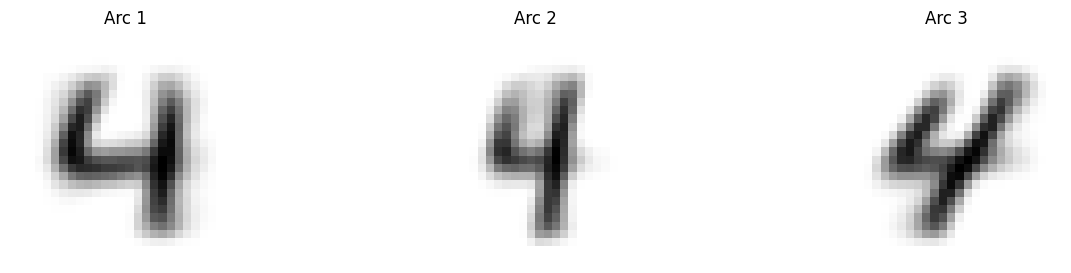

In [42]:
# --- REVISED VISUALIZATION BLOCK (The Definitive Fix) ---
import torch

# Assuming the variables C and X are available from the analysis run
# C is the first output from the analysis, which we now assume is the convex hull coefficient matrix (A)

# Ensure C and X are on the CPU and detached for calculation
if isinstance(C, torch.Tensor):
    A_matrix = C.detach().cpu() 
else:
    A_matrix = torch.from_numpy(C)

if isinstance(X, torch.Tensor):
    X_data = X.detach().cpu()
else:
    X_data = torch.from_numpy(X)

# 1. Calculate the true Archetype Matrix (C = X @ A)
# C_plot shape will be (784, 2000) @ (2000, 10) = (784, 10)
C_plot = X_data @ A_matrix 

# 2. Convert to NumPy for plotting
C_np = C_plot.numpy()
n_archetypes = C_np.shape[1]

print(f"Final Archetype Matrix shape for plotting: {C_np.shape}") # Should be (784, 10)

# 3. Plotting Loop
fig, axes = plt.subplots(1, n_archetypes, figsize=(15, 3))
for i in range(n_archetypes):
    # This now uses the calculated (784, 10) matrix
    digit = C_np[:, i].reshape(28, 28)
    
    axes[i].imshow(digit, cmap='gray_r')
    axes[i].axis('off')
    axes[i].set_title(f'Arc {i+1}')

plt.show()

---

### Guassian Method

In [44]:
# Run the Gaussian archetypes too
print(f"Finding {n_archetypes} Bernoulli Archetypes...")

C_, S_, L_, EV_ = AALS(X, n_archetypes) # Use the AALS function

Finding 3 Bernoulli Archetypes...


In [46]:
# Save the results for later visualization
torch.save({'C': C_, 'S': S_, 'L': L_}, 'mnist_gaussian_aa_results.pth')

Final Archetype Matrix shape for plotting: (784, 3)


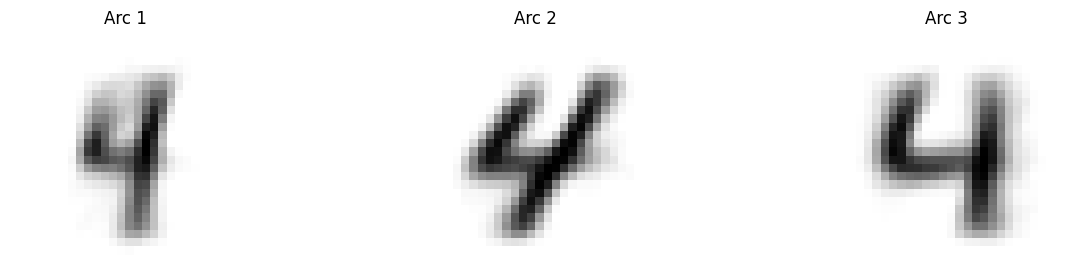

In [ ]:
# --- REVISED VISUALIZATION BLOCK (The Definitive Fix) ---
import torch

# Assuming the variables C and X are available from the analysis run
# C is the first output from the analysis, which we now assume is the convex hull coefficient matrix (A)

# Ensure C and X are on the CPU and detached for calculation
if isinstance(C_, torch.Tensor):
    A_matrix = C_.detach().cpu() 
else:
    A_matrix = torch.from_numpy(C_)

if isinstance(X, torch.Tensor):
    X_data = X.detach().cpu()
else:
    X_data = torch.from_numpy(X)

# 1. Calculate the true Archetype Matrix (C = X @ A)
# C_plot shape will be (784, 2000) @ (2000, 10) = (784, 10)
C_plot = X_data @ A_matrix 

# 2. Convert to NumPy for plotting
C_np = C_plot.numpy()
n_archetypes = C_np.shape[1]

print(f"Final Archetype Matrix shape for plotting: {C_np.shape}") # Should be (784, 10)

# 3. Plotting Loop
fig, axes = plt.subplots(1, n_archetypes, figsize=(15, 3))
for i in range(n_archetypes):
    # This now uses the calculated (784, 10) matrix
    digit = C_np[:, i].reshape(28, 28)
    
    axes[i].imshow(digit, cmap='gray_r')
    axes[i].axis('off')
    axes[i].set_title(f'Arc {i+1}')

plt.show()